In [1]:
import torch
from torch import nn
from torch import optim
from torchvision import models
import torchvision.transforms.v2 as tfs

from PIL import Image
from urllib.request import urlopen
import numpy as np
import matplotlib.pyplot as plt

Epoch: [1/100], loss: 668.1425
Epoch: [2/100], loss: 475.6121
Epoch: [3/100], loss: 349.7662
Epoch: [4/100], loss: 259.8627
Epoch: [5/100], loss: 206.0081
Epoch: [6/100], loss: 162.8131
Epoch: [7/100], loss: 135.3094
Epoch: [8/100], loss: 115.4767
Epoch: [9/100], loss: 100.8918
Epoch: [10/100], loss: 91.3138
Epoch: [11/100], loss: 83.6738
Epoch: [12/100], loss: 76.8043
Epoch: [13/100], loss: 70.6781
Epoch: [14/100], loss: 65.7979
Epoch: [15/100], loss: 61.6525
Epoch: [16/100], loss: 57.9315
Epoch: [17/100], loss: 54.7026
Epoch: [18/100], loss: 51.8649
Epoch: [19/100], loss: 49.2391
Epoch: [20/100], loss: 46.8787
Epoch: [21/100], loss: 44.8470
Epoch: [22/100], loss: 42.9958
Epoch: [23/100], loss: 41.3487
Epoch: [24/100], loss: 39.8636
Epoch: [25/100], loss: 38.4690
Epoch: [26/100], loss: 37.1385
Epoch: [27/100], loss: 35.9264
Epoch: [28/100], loss: 34.7765
Epoch: [29/100], loss: 33.6676
Epoch: [30/100], loss: 32.6294
Epoch: [31/100], loss: 31.6563
Epoch: [32/100], loss: 30.7164
Epoch: [

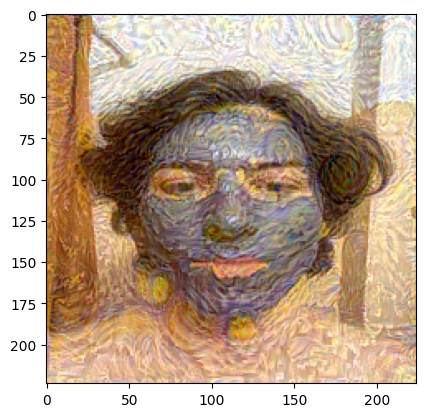

In [4]:
class StylizationModel(nn.Module):
    def __init__(self):
        super().__init__()
        _model = models.vgg19(weights=models.VGG19_Weights.DEFAULT)
        self.mf = _model.features
        self.mf.requires_grad_(False)
        self.requires_grad_(False)
        self.mf.eval()
        self.idx_out = (0, 5, 10, 19, 28, 34)  # индексы слоёв, с которых мы будем брать данные. последний свёрточный слой с индексом 34 будет использоваться для определения потерь по контенту
        self.num_style_layers = len(self.idx_out)  # определяет количесвто свёрточных слоёв, используемых для вычисления потерь по стилю

    def forward(self, x):
        outputs = []
        for indx, layer in enumerate(self.mf):
            x = layer.forward(x)
            if indx in self.idx_out:
                outputs.append(x.squeeze(0))
        return outputs


def get_content_loss(base_content, target):
    return torch.mean(torch.square(base_content - target))


def gram_matrix(x):
    channels = x.size(dim=0)
    g = x.view(channels, -1)
    gram = torch.mm(g, g.mT) / g.size(dim=1)
    return gram


def get_style_loss(base_style, gram_target):
    style_weights = [1.0, 0.8, 0.5, 0.3, 0.1]

    _loss = 0
    i = 0
    for base, target in zip(base_style, gram_target):
        gram_style = gram_matrix(base)
        _loss += style_weights[i] * torch.mean(torch.square(gram_style - target))
        i += 1

    return _loss

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

img = Image.open('1.jpg').convert('RGB')
img_style = Image.open('2.jpg').convert('RGB')

transforms = tfs.Compose([tfs.ToImage(),
                         tfs.ToDtype(torch.float32, scale='True'),
                         tfs.Resize(size=(224, 224))])

img = transforms(img).unsqueeze(0).to(device)
img_style = transforms(img_style).unsqueeze(0).to(device)

img_create = img.clone()
img_create.requires_grad_(True)

model = StylizationModel().to(device)

outputs_img = model.forward(img)
outputs_img_style = model.forward(img_style)

gram_matrix_style = [gram_matrix(x) for x in outputs_img_style[:model.num_style_layers]]

content_weight = 1
style_weight = 1000
best_loss = -1
epochs = 100
best_img = img_create.clone()

optimizer = optim.Adam(params=[img_create], lr=0.01)

for epoch in range(epochs):
    outputs_img_create = model.forward(img_create)

    loss_content = get_content_loss(outputs_img_create[-1], outputs_img[-1])
    loss_style = get_style_loss(outputs_img_create[:-1], gram_matrix_style)
    loss = content_weight * loss_content + style_weight * loss_style

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    img_create.data.clamp_(0, 1)

    if loss < best_loss or best_loss < 0:
        best_loss = loss
        best_img = img_create.clone()

    print(f'Epoch: [{epoch + 1}/{epochs}], loss: {loss.item():.4f}')


x = best_img.detach().squeeze()
low, hi = torch.amin(x), torch.amax(x)
x = (x - low) / (hi - low) * 255.0
x = x.permute(1, 2, 0)
x = x.cpu()
x = x.numpy()
x = np.clip(x, 0, 255).astype('uint8')

image = Image.fromarray(x, 'RGB')
image.save('3.jpg')

plt.imshow(x)